In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install vit-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00


In [39]:
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import sys
import cv2 # Pour utiliser opencv-python, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

from vit_pytorch import ViT
from vit_pytorch import SimpleViT
from tqdm.notebook import tqdm

np.random.seed(0)

In [4]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
DATA_FOLDER_PATH = '/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/'
JPEGIMAGES_FOLDER_PATH = '/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/JPEGImages/'

In [5]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): #-> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()
print(num_images_per_label)
print(proportions_images_per_label)

{'elephant': 1038, 'lion': 1019, 'deer': 1344, 'cow': 1338, 'squirrel': 1200, 'german+shepherd': 1033, 'skunk': 188, 'horse': 1645, 'mole': 100, 'walrus': 215, 'weasel': 282, 'mouse': 185, 'buffalo': 904, 'grizzly+bear': 852, 'bat': 383, 'chimpanzee': 728, 'beaver': 193, 'rabbit': 1088, 'wolf': 589, 'bobcat': 630, 'seal': 988, 'collie': 1028, 'spider+monkey': 291, 'otter': 758, 'rat': 310, 'leopard': 720, 'zebra': 1170, 'sheep': 1420, 'blue+whale': 174, 'ox': 728, 'chihuahua': 567, 'hamster': 779, 'tiger': 877, 'giraffe': 1202, 'polar+bear': 868, 'dolphin': 946, 'fox': 664, 'siamese+cat': 500, 'persian+cat': 747, 'raccoon': 512, 'antelope': 1046, 'pig': 713, 'giant+panda': 874, 'killer+whale': 291, 'moose': 704, 'dalmatian': 549, 'humpback+whale': 709, 'gorilla': 872, 'rhinoceros': 696, 'hippopotamus': 684}
{'elephant': 0.0278, 'lion': 0.0273, 'deer': 0.036, 'cow': 0.0358, 'squirrel': 0.0321, 'german+shepherd': 0.0277, 'skunk': 0.005, 'horse': 0.0441, 'mole': 0.0027, 'walrus': 0.0058, 

In [12]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Sucessfully created annotations.csv file.


In [34]:
# labels_in_number = pd.read_csv(DATA_FOLDER_PATH+"classes.txt", delim_whitespace=True,header=None)
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        # print(line.split())
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [13]:
from torchvision.io import read_image, ImageReadMode
from PIL import Image


class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(path = img_path, mode = ImageReadMode.RGB)
        # with open(img_path, 'rb') as f:
        #     image = Image.open(f)
        #     image = image.convert('RGB')  # convert to RGB


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class Subset_(AWA2Dataset) : 
    def __init__(self, dataset, indices, transform=None):
        super().__init__()
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index_in_AWA2Dataset = self.indices[index]
        image, label = self.dataset[original_index_in_AWA2Dataset]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

In [9]:
# dataset = AWA2Dataset()

# # print(type(dataset))

# random_index = np.random.randint(0, len(dataset))
# image, label = dataset[random_index]

# ## TODO : Change transforms. Currently this is not useful.
# dataset.transform = transforms.Compose([
#                         transforms.ToPILImage(),
#                         transforms.Resize((224, 224)),
#                         # transforms.RandomHorizontalFlip(),
#                         transforms.Grayscale(num_output_channels=3),
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.485, 0.456, 0.406), 
#                                              (0.229, 0.224, 0.225))])

# # print(dataset[0][0].shape)

# train_size =  10
# test_size = 5
# # valid_size = 2

# train_list, list_1 = torch.utils.data.random_split(dataset, [train_size,len(dataset)-train_size])
# test_list, list_2 = torch.utils.data.random_split(list_1, [test_size,len(list_1)-test_size])
# # train_list, valid_list = torch.utils.data.random_split(train_list, [train_size-valid_size,valid_size])

# # print(type(train_list))
# # valid_list, list_ =  torch.utils.data.random_split(list_2, [valid_size,len(list_2)-valid_size])
# # Testing. All good
# # train_list = []
# # test_list = []

# # for i in range(10):
# #     random_index = np.random.randint(0, len(dataset))
# #     train_list.append(dataset[random_index])

# # for i in range(5):
# #     random_index = np.random.randint(0, len(dataset))
# #     test_list.append(dataset[random_index])
    



# from sklearn.model_selection import train_test_split

# train_list, valid_list = train_test_split(train_list, 
#                                           test_size=0.5)

# print(f"Train Data: {len(train_list)}")
# print(f"Test Data: {len(test_list)}")
# print(f"Validation Data: {len(valid_list)}")


In [14]:
transforms_pipeline_train = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    
                    ## Data augmentation 
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(p=0.4),
                    # transforms.RandomApply(transforms.RandAugment(), p=0.4), # 40% of the time, apply a random additional combo of transformations #https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
                    transforms.ColorJitter(brightness=0.2,
                                            contrast=0.2,
                                            saturation=0.2,
                                            hue=0.1),
                    transforms.RandomCrop((224,224)),  # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 0.9), ratio=(0.5, 1.08,))
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_pipeline_test = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    transforms.CenterCrop((224,224)),   
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])




# Initialize dataset and train/valid/test split 
from sklearn.model_selection import train_test_split

dataset = AWA2Dataset()
n_images = len(dataset)
# Split all indices into training/testing sets
train_indices, test_indices = train_test_split(range(n_images), test_size=0.2, random_state=1)
# Split training indices into training/validation sets.
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=1)


# Initialize the 3 DataSet objects (as Subset_) and apply the relevant Transforms to each subset (train/test/valid)
train_data = Subset_(dataset, train_indices, transform = transforms_pipeline_train)
valid_data = Subset_(dataset, valid_indices, transform = transforms_pipeline_test)
test_data  = Subset_(dataset, test_indices, transform = transforms_pipeline_test) 

# Initalize DataLoaders
batch_size = 32
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

In [11]:
# train_list.transforms = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]
# )

# val_transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )


# test_transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )
# train_data = AWA2Dataset(dataset)
# valid_data = AWA2Dataset(valid_list, transform=test_transforms)
# test_data = AWA2Dataset(test_list, transform=test_transforms)


# train_data = train_list
# valid_data = train_list
# test_data = train_list

# train_data.transforms = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]
# )

# valid_data.transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )


# test_data.transforms = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]
# )

# print(train_list[1][0].shape)

# train_dataloader = DataLoader(train_data, batch_size=4, shuffle= True)
# test_dataloader = DataLoader(test_data, batch_size=4, shuffle= True)
# valid_dataloader = DataLoader(valid_data, batch_size=4, shuffle= True)

In [13]:
import torch.nn as nn
# import timm
from vit_pytorch import ViT
from vit_pytorch import SimpleViT
# from vit_pytorch.efficient import ViT
# from linformer import Linformer

# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )
# vit_model =  ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=50,
#     transformer=efficient_transformer,
#     channels=3,
# )

vit_model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 50,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1 ### ADDED DROP OUT 
)



vit_model.eval

<bound method Module.eval of ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((10

### ViT-ZSL ###

In [14]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [15]:
torch.cuda.is_available()

True

In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14532498523855041453
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13854638080
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6644528785712227593
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [17]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [18]:
vit_model.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_

### Question: check dimension de dataloader   ###

### TEST Split training data and test data ###

In [19]:
# batch_size = 8

# train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
# valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

# dataset = test_train
# dataloader = DataLoader(dataset = test_train, batch_size=batch_size, shuffle=True)
# train_size = int(0.8*len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])
# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=2, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=2, pin_memory=True)

###  Split training data and test data ###

In [20]:
# batch_size = 128

In [21]:
# dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
# train_size = int(0.8*len(dataset))
# test_size = len(dataset) - train_size

In [22]:
# train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])

In [23]:
# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=12, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=12, pin_memory=True)

###   transfomer labels  ###

In [35]:
path_class = DATA_FOLDER_PATH +"classes.txt"
class_animal = pd.read_table(path_class,header= None)
# class_animal

In [36]:
animals = class_animal[1]
dict_label_animal = {}
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels) 



###   Loss function  ###

In [26]:
lr = 1e-3

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

# vit_pytorch
# optimizer = optim.SGD(vit_model.parameters(), lr= lr, momentum=0.9)

# optimizer = optim.Adam(vit_model.parameters(), lr=lr)

# ViT-ZSL
# optimizer = torch.optim.Adam([{"params": vit_model.layers_dict.vit.parameters(), "lr": 0.00001, "weight_decay": 0.0001},
#                               {"params": vit_model.layers_dict.mlp_g.parameters(), "lr": 0.001, "weight_decay": 0.00001}])

In [ ]:
import torch.nn as nn
from vit_pytorch import ViT
from vit_pytorch import SimpleViT

vit_model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 50,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1 ### ADDED DROP OUT RATE
    # emb_dropout = 0.1 ### ADDED Embedding dropout rate 
)
vit_model.to(device)

###  Training  ###

Depth: 12-16 layers
Number of attention heads: 8-12
MLP hidden layer dimension: 2048-4096

In [ ]:
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm


def collate_fn(batch):
   batch = list(filter(lambda x: x is not None, batch))
   return torch.utils.data.dataloader.default_collate(batch) 





batch_size = 64

# train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, collate_fn=collate_fn) #suggested_max_workers_for_colab_env = 6
# valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, num_workers=6, collate_fn=collate_fn)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True, num_workers=6, collate_fn=collate_fn)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6) #suggested_max_workers_for_colab_env = 6
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True, num_workers=6)



# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(vit_model.parameters(), lr=3e-5, weight_decay=1e-5) ### Added weight decay 
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(20):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = vit_model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = vit_model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.8478 - acc: 0.2455 - val_loss : 2.7508 - val_acc: 0.2615



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.7460 - acc: 0.2700 - val_loss : 2.6805 - val_acc: 0.2887



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.6652 - acc: 0.2877 - val_loss : 2.5692 - val_acc: 0.3111



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.5663 - acc: 0.3075 - val_loss : 2.5200 - val_acc: 0.3215



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.5145 - acc: 0.3203 - val_loss : 2.5082 - val_acc: 0.3247



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.4505 - acc: 0.3342 - val_loss : 2.3837 - val_acc: 0.3556



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.4097 - acc: 0.3441 - val_loss : 2.3538 - val_acc: 0.3648



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.3636 - acc: 0.3541 - val_loss : 2.3309 - val_acc: 0.3693



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 9 - loss : 2.3146 - acc: 0.3647 - val_loss : 2.3349 - val_acc: 0.3720



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 10 - loss : 2.2730 - acc: 0.3757 - val_loss : 2.2564 - val_acc: 0.3838



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 11 - loss : 2.2486 - acc: 0.3815 - val_loss : 2.2430 - val_acc: 0.3863



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 12 - loss : 2.2009 - acc: 0.3912 - val_loss : 2.2180 - val_acc: 0.3938



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 13 - loss : 2.1743 - acc: 0.4012 - val_loss : 2.2164 - val_acc: 0.3904



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 14 - loss : 2.1390 - acc: 0.4062 - val_loss : 2.1780 - val_acc: 0.4047



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 15 - loss : 2.1061 - acc: 0.4121 - val_loss : 2.1271 - val_acc: 0.4186



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 16 - loss : 2.0825 - acc: 0.4202 - val_loss : 2.1240 - val_acc: 0.4194



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 17 - loss : 2.0597 - acc: 0.4257 - val_loss : 2.1320 - val_acc: 0.4206



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 18 - loss : 2.0172 - acc: 0.4358 - val_loss : 2.1083 - val_acc: 0.4195



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 19 - loss : 1.9961 - acc: 0.4403 - val_loss : 2.0828 - val_acc: 0.4355



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 20 - loss : 1.9739 - acc: 0.4463 - val_loss : 2.0506 - val_acc: 0.4327



In [ ]:
import torch.nn as nn
from vit_pytorch import ViT
from vit_pytorch import SimpleViT


vit_model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 50,
    dim = 1024,
    depth = 12, # NEW 
    heads = 10, # NEW
    mlp_dim = 4096, # NEW
    dropout = 0.1 ### ADDED DROP OUT RATE
    # emb_dropout = 0.1 ### ADDED Embedding dropout rate 
)
vit_model.to(device)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

import torch.optim as optim

def collate_fn(batch):
   batch = list(filter(lambda x: x is not None, batch))
   return torch.utils.data.dataloader.default_collate(batch) 


batch_size = 128

# train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, collate_fn=collate_fn) #suggested_max_workers_for_colab_env = 6
# valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, num_workers=6, collate_fn=collate_fn)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True, num_workers=6, collate_fn=collate_fn)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6) #suggested_max_workers_for_colab_env = 6
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True, num_workers=6)



# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=1e-5) ### Added weight decay 
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


# Define the OneCycleLR scheduler with a maximum learning rate of 0.01, a total number of epochs of 20, and a warm-up phase of 5 epochs
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=len(train_loader)*20, epochs=20, steps_per_epoch=len(train_loader), anneal_strategy='cos', div_factor=10, pct_start=0.2)


for epoch in range(20):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = vit_model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = vit_model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.4936 - acc: 0.1035 - val_loss : 3.1666 - val_acc: 0.1803



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.0671 - acc: 0.1903 - val_loss : 2.9338 - val_acc: 0.2308



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.8620 - acc: 0.2356 - val_loss : 2.6769 - val_acc: 0.2828



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.7101 - acc: 0.2736 - val_loss : 2.5961 - val_acc: 0.2973



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.5938 - acc: 0.2996 - val_loss : 2.5093 - val_acc: 0.3261



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.4952 - acc: 0.3215 - val_loss : 2.4045 - val_acc: 0.3510



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.4082 - acc: 0.3456 - val_loss : 2.3712 - val_acc: 0.3540



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.3431 - acc: 0.3574 - val_loss : 2.2974 - val_acc: 0.3722



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 9 - loss : 2.2630 - acc: 0.3778 - val_loss : 2.2478 - val_acc: 0.3856



  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
import torch.nn as nn
from vit_pytorch import ViT
from vit_pytorch import SimpleViT

vit_model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 50,
    dim = 1024,
    depth = 12, # was 8
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1 ### ADDED DROP OUT RATE
    # emb_dropout = 0.1 ### ADDED Embedding dropout rate 
)
vit_model.to(device)

In [41]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

batch_size = 128
epochs = 50

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)#suggested_max_workers_for_colab_env = 6
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=1e-5) ### Added weight decay 

# scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=len(train_loader)*20, epochs=20, steps_per_epoch=len(train_loader), anneal_strategy='cos', div_factor=10, pct_start=0.2)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)





# Define the Adam optimizer with a learning rate of 0.001
# optimizer = optim.Adam(vit_model.parameters(), lr=0.001)

# scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
# Define the OneCycleLR scheduler with a maximum learning rate of 0.01, a total number of epochs of 20, and a warm-up phase of 5 epochs
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=len(train_loader)*20, epochs=20, steps_per_epoch=len(train_loader), anneal_strategy='cos', div_factor=10, pct_start=0.2)


# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3)



scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=len(train_loader)*20, epochs=20, steps_per_epoch=len(train_loader), anneal_strategy='cos', div_factor=10, pct_start=0.05)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)






wandb.init(
    # set the wandb project where this run will be logged
    project="ViT-test-py",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "ViT",
    "dataset": "AWA2",
    "epochs": 20,
    }
)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = vit_model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = vit_model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    # log metrics to wandb
    wandb.log({"loss" : epoch_loss , "acc": epoch_accuracy, "val_loss" : epoch_val_loss, "val_acc": epoch_val_accuracy})


# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

# for epoch in range(20):
#     epoch_loss = 0
#     epoch_accuracy = 0

#     for data, label in tqdm(train_loader):
#         data = data.to(device)
#         label = label.to(device)

#         output = vit_model(data)
#         loss = criterion(output, label)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # scheduler.step()

#         acc = (output.argmax(dim=1) == label).float().mean()
#         epoch_accuracy += acc / len(train_loader)
#         epoch_loss += loss / len(train_loader)

#     with torch.no_grad():
#         epoch_val_accuracy = 0
#         epoch_val_loss = 0
#         for data, label in valid_loader:
#             data = data.to(device)
#             label = label.to(device)

#             val_output = vit_model(data)
#             val_loss = criterion(val_output, label)

#             acc = (val_output.argmax(dim=1) == label).float().mean()
#             epoch_val_accuracy += acc / len(valid_loader)
#             epoch_val_loss += val_loss / len(valid_loader)

#     print(
#         f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
#     )

wandb: Currently logged in as: othmanesajid01 (animal-detect-vit). Use `wandb login --relogin` to force relogin


  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.5072 - acc: 0.3219 - val_loss : 2.4490 - val_acc: 0.3358



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.4147 - acc: 0.3444 - val_loss : 2.4604 - val_acc: 0.3371



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.3212 - acc: 0.3651 - val_loss : 2.3429 - val_acc: 0.3561



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.2690 - acc: 0.3783 - val_loss : 2.2694 - val_acc: 0.3782



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.2016 - acc: 0.3938 - val_loss : 2.2454 - val_acc: 0.3886



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.1507 - acc: 0.4056 - val_loss : 2.1914 - val_acc: 0.3949



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.0999 - acc: 0.4166 - val_loss : 2.1734 - val_acc: 0.4044



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.0414 - acc: 0.4301 - val_loss : 2.1067 - val_acc: 0.4198



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.9860 - acc: 0.4440 - val_loss : 2.0823 - val_acc: 0.4229



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.9405 - acc: 0.4534 - val_loss : 2.0580 - val_acc: 0.4362



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 11 - loss : 1.8956 - acc: 0.4630 - val_loss : 2.0367 - val_acc: 0.4369



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.8412 - acc: 0.4802 - val_loss : 2.0183 - val_acc: 0.4434



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 13 - loss : 1.7892 - acc: 0.4923 - val_loss : 1.9907 - val_acc: 0.4532



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 14 - loss : 1.7179 - acc: 0.5084 - val_loss : 1.9646 - val_acc: 0.4667



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 15 - loss : 1.6684 - acc: 0.5195 - val_loss : 1.9516 - val_acc: 0.4608



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 16 - loss : 1.6375 - acc: 0.5274 - val_loss : 1.8845 - val_acc: 0.4843



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 17 - loss : 1.5649 - acc: 0.5436 - val_loss : 1.8800 - val_acc: 0.4754



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 18 - loss : 1.5232 - acc: 0.5597 - val_loss : 1.8592 - val_acc: 0.4894



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 19 - loss : 1.4715 - acc: 0.5713 - val_loss : 1.8654 - val_acc: 0.4917



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 20 - loss : 1.4232 - acc: 0.5821 - val_loss : 1.8874 - val_acc: 0.4878



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 21 - loss : 1.3907 - acc: 0.5876 - val_loss : 1.8736 - val_acc: 0.4975



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 22 - loss : 1.3304 - acc: 0.6072 - val_loss : 1.8368 - val_acc: 0.5024



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 23 - loss : 1.2893 - acc: 0.6136 - val_loss : 1.8280 - val_acc: 0.5069



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 24 - loss : 1.2371 - acc: 0.6324 - val_loss : 1.7992 - val_acc: 0.5102



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 25 - loss : 1.1773 - acc: 0.6475 - val_loss : 1.8427 - val_acc: 0.5113



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 26 - loss : 1.1358 - acc: 0.6570 - val_loss : 1.8356 - val_acc: 0.5201



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 27 - loss : 1.0925 - acc: 0.6673 - val_loss : 1.8205 - val_acc: 0.5262



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 28 - loss : 1.0465 - acc: 0.6826 - val_loss : 1.8139 - val_acc: 0.5215



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.9915 - acc: 0.6956 - val_loss : 1.8567 - val_acc: 0.5182



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.9443 - acc: 0.7098 - val_loss : 1.8137 - val_acc: 0.5327



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.8884 - acc: 0.7250 - val_loss : 1.8527 - val_acc: 0.5234



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.8600 - acc: 0.7339 - val_loss : 1.8764 - val_acc: 0.5241



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.8066 - acc: 0.7468 - val_loss : 1.8899 - val_acc: 0.5245



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.7694 - acc: 0.7608 - val_loss : 1.9069 - val_acc: 0.5154



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.7339 - acc: 0.7696 - val_loss : 1.8981 - val_acc: 0.5382



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.7011 - acc: 0.7787 - val_loss : 1.8874 - val_acc: 0.5306



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6511 - acc: 0.7964 - val_loss : 1.9259 - val_acc: 0.5305



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6046 - acc: 0.8078 - val_loss : 1.9366 - val_acc: 0.5339



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.5748 - acc: 0.8177 - val_loss : 2.0235 - val_acc: 0.5154



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5482 - acc: 0.8246 - val_loss : 1.9965 - val_acc: 0.5308



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.5179 - acc: 0.8357 - val_loss : 2.0024 - val_acc: 0.5323



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.4858 - acc: 0.8450 - val_loss : 2.0013 - val_acc: 0.5307



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.4573 - acc: 0.8566 - val_loss : 2.0785 - val_acc: 0.5332



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.4346 - acc: 0.8601 - val_loss : 2.0489 - val_acc: 0.5373



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.4168 - acc: 0.8645 - val_loss : 2.0574 - val_acc: 0.5431



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.3966 - acc: 0.8723 - val_loss : 2.1221 - val_acc: 0.5388



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.3676 - acc: 0.8806 - val_loss : 2.1583 - val_acc: 0.5303



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.3548 - acc: 0.8858 - val_loss : 2.1356 - val_acc: 0.5334



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3470 - acc: 0.8891 - val_loss : 2.1630 - val_acc: 0.5346



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.3348 - acc: 0.8916 - val_loss : 2.1081 - val_acc: 0.5468



acc,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███▇██
val_loss,██▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▄
acc,0.89164
loss,0.33485
val_acc,0.54675
val_loss,2.1081


In [8]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [9]:
torch.cuda.is_available()

True

In [ ]:
# save model to file in Google Drive
model_path = '/content/drive/MyDrive/IFT3710/ViT/vit_model_53percentAcc.pth'
torch.save(vit_model.state_dict(), model_path)

In [10]:
# Load model 

import torch
import torch.nn as nn
from vit_pytorch import ViT
from vit_pytorch import SimpleViT


# Initialize empty model with same architecture.
vit_model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 50,
    dim = 1024,
    depth = 12, # was 8
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1 ### ADDED DROP OUT RATE
    # emb_dropout = 0.1 ### ADDED Embedding dropout rate 
)
vit_model.to(device)


# load saved model state dict
model_path = '/content/drive/MyDrive/IFT3710/ViT/vit_model_53percentAcc.pth'
vit_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

### Test ###

In [27]:
!pip install -Uqq ipdb
import ipdb
%pdb off

Automatic pdb calling has been turned OFF


In [23]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)#suggested_max_workers_for_colab_env = 6
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

correct = 0
total = 0
y_true = []
y_pred = []
wrong_pred =[]
right_label = []
with torch.no_grad():
    # for data in test_loader:
    for data in tqdm(test_loader):
    # for data, labels in tqdm(test_loader) :
        # data = data.to(device)
        # labels = label.to(device)
        # output = vit_model(data)
        
        images = data[0].to(device)
        labels = data[1].to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        # ipdb.set_trace(context=6)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        # ipdb.set_trace(context=6)
        total += labels.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != labels[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(labels[i].item())
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

  0%|          | 0/234 [00:00<?, ?it/s]

Accuracy of the network on the test images: 53 %


###   Analyse  ###

In [31]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt

In [32]:
nb_wrong_pred = []
for i in range(0,50):
    nb_wrong_pred.append(wrong_pred.count(i))

In [37]:
list_animal = list(dict_label_animal.keys())

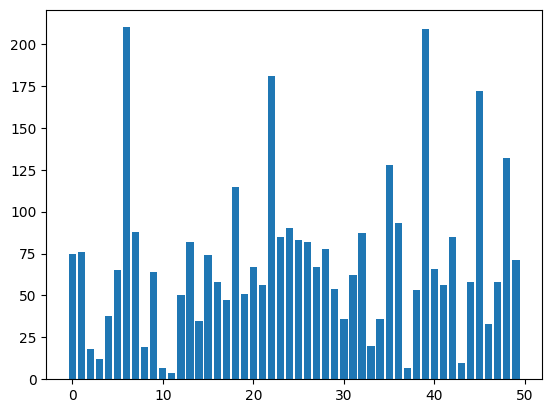

In [38]:
plt.bar(range(50), nb_wrong_pred)
plt.show()

In [39]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_wrong_pred[i]<=75:
        good_classification.append(i)
    if    nb_wrong_pred[i]>=100:
        bad_classification.append(i)

In [40]:
def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(wrong_pred) if x == m]:
        wrong_pred_m.append(right_label[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

In [58]:
for i in good_classification :
    print('ViT a bien classifie '+animals[i])

ViT a bien classifie killer+whale
ViT a bien classifie beaver
ViT a bien classifie dalmatian
ViT a bien classifie persian+cat
ViT a bien classifie blue+whale
ViT a bien classifie siamese+cat
ViT a bien classifie skunk
ViT a bien classifie mole
ViT a bien classifie tiger
ViT a bien classifie hippopotamus
ViT a bien classifie leopard
ViT a bien classifie moose
ViT a bien classifie spider+monkey
ViT a bien classifie humpback+whale
ViT a bien classifie gorilla
ViT a bien classifie ox
ViT a bien classifie fox
ViT a bien classifie hamster
ViT a bien classifie squirrel
ViT a bien classifie rhinoceros
ViT a bien classifie rabbit
ViT a bien classifie bat
ViT a bien classifie giraffe
ViT a bien classifie wolf
ViT a bien classifie rat
ViT a bien classifie weasel
ViT a bien classifie zebra
ViT a bien classifie giant+panda
ViT a bien classifie bobcat
ViT a bien classifie pig
ViT a bien classifie mouse
ViT a bien classifie polar+bear
ViT a bien classifie walrus
ViT a bien classifie raccoon
ViT a bie

In [54]:
for i in bad_classification:
    print('ViT a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

ViT a mal classifie antelope , melange souvent avec deer
ViT a mal classifie grizzly+bear , melange souvent avec lion
ViT a mal classifie persian+cat , melange souvent avec hamster
ViT a mal classifie horse , melange souvent avec cow
ViT a mal classifie german+shepherd , melange souvent avec chihuahua
ViT a mal classifie siamese+cat , melange souvent avec persian+cat
ViT a mal classifie hippopotamus , melange souvent avec seal
ViT a mal classifie moose , melange souvent avec deer
ViT a mal classifie elephant , melange souvent avec rhinoceros
ViT a mal classifie ox , melange souvent avec cow
ViT a mal classifie fox , melange souvent avec deer
ViT a mal classifie sheep , melange souvent avec cow
ViT a mal classifie seal , melange souvent avec otter
ViT a mal classifie chimpanzee , melange souvent avec gorilla
ViT a mal classifie hamster , melange souvent avec persian+cat
ViT a mal classifie squirrel , melange souvent avec rabbit
ViT a mal classifie rhinoceros , melange souvent avec hippo

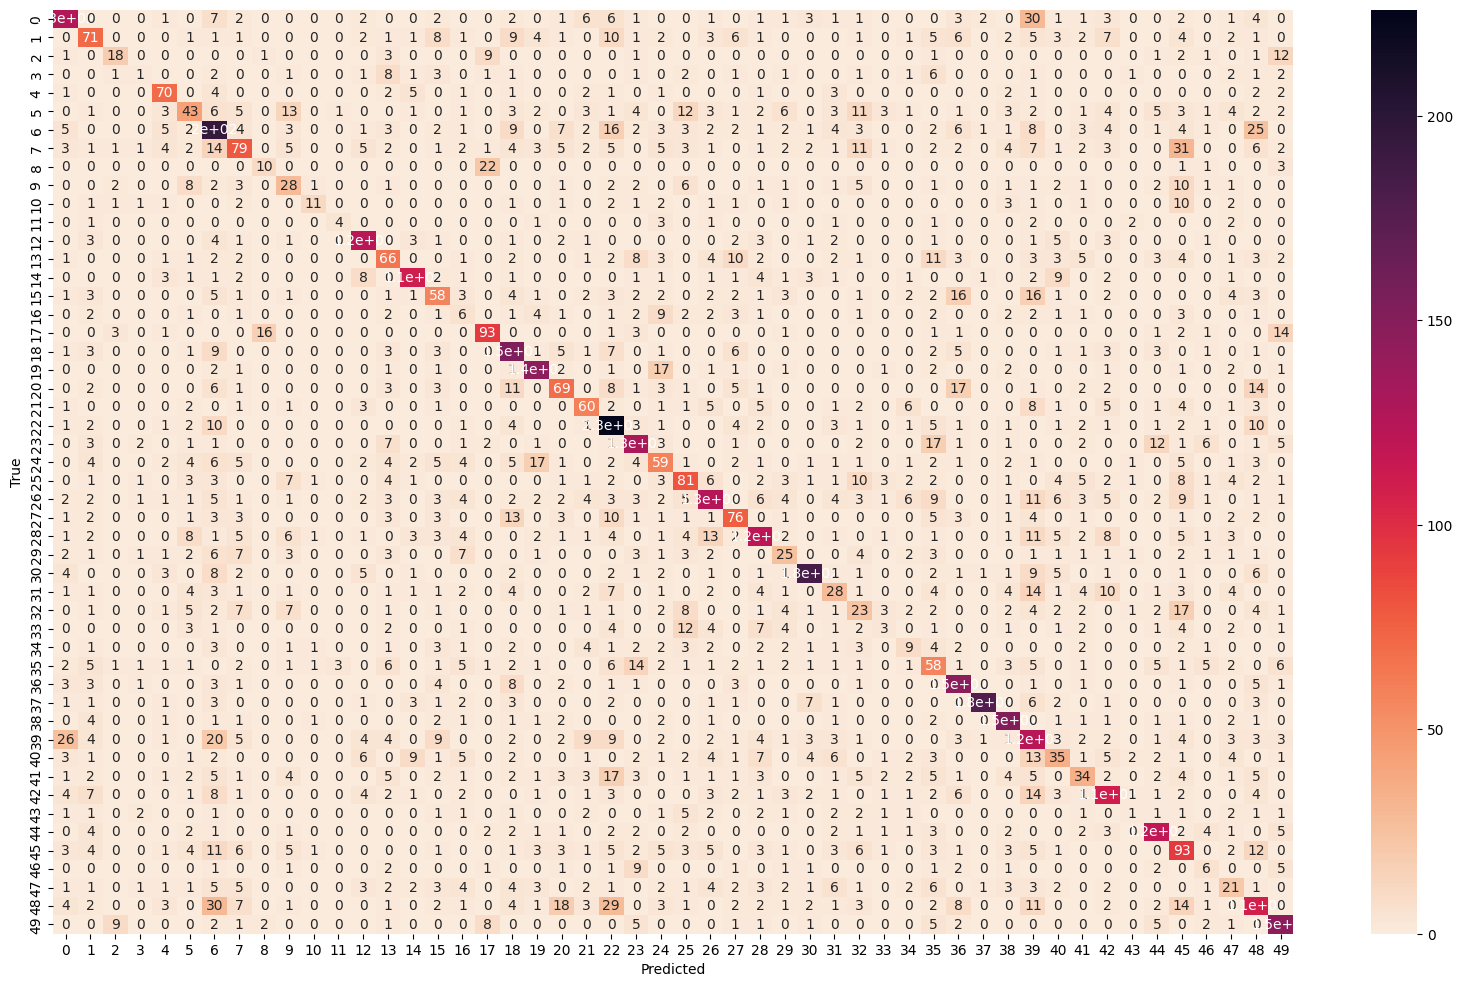

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred)

# Seaborn heatmap
fig, ax = plt.subplots(figsize=(20,12))  
sns.heatmap(confusion_mat, annot=True, cmap='rocket_r')

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show plot
plt.show()